In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from joblib import dump, load
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import csv
from sklearn.base import BaseEstimator, ClassifierMixin


In [2]:
# Step 2: Load and preprocess data
data = []
directory = "stock_data_all/Finance/1"

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        print(f"Reading file: {filepath}")
        dt = pd.read_csv(filepath)
        data.append(dt)

# Concatenate all DataFrames in the list into a single DataFrame
data = pd.concat(data, ignore_index=True)

scaler = StandardScaler()
data_ = scaler.fit_transform(data.iloc[:, 1:].values)

ten_day_change = data["Close"].pct_change(periods=10) * 100
fixed_bins = [-float("inf"), -10, -2, 2, 10, float("inf")]
fixed_labels = [0, 1, 2, 3, 4]

# Discretize the '10_day_change' column based on fixed percentage change
ten_day_change_fixed_discrete = pd.cut(ten_day_change, bins=fixed_bins, labels=fixed_labels)

def split_data(stock, lookback, interval, y):
    data_raw = np.array(stock)
    n_time = len(data_raw)
    data, targets = [], []
    for index in range(0, n_time - lookback, interval):
        data.append(data_raw[index : index + lookback, :])
        targets.append(y.iloc[index + lookback])

    data = np.array(data)
    targets = np.array(targets)
    print("總資料量:{}".format(data.shape))

    x_train, x_test, y_train, y_test = train_test_split(
        data, targets, test_size=0.2, shuffle=True, random_state=42
    )

    return x_train, y_train, x_test, y_test

lookback = 60  # choose sequence length
interval = 10  # sample days difference
x_train, y_train, x_test, y_test = split_data(data_, lookback, interval, ten_day_change_fixed_discrete)
print("x_train.shape =", x_train.shape)
print("y_train.shape =", y_train.shape)
print("x_test.shape =", x_test.shape)
print("y_test.shape =", y_test.shape)

# For MLP and SVM, reshape the data to 2D
x_train_ml = x_train.reshape(x_train.shape[0], -1)
x_test_ml = x_test.reshape(x_test.shape[0], -1)

# Transform data for PyTorch
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)

def transform_type_train(x, device):
    return torch.Tensor(x.astype(np.float32)).to(device)

def transform_type_test(y, device):
    return torch.Tensor(y.astype(int)).to(torch.int64).to(device)

x_train_ = transform_type_train(x_train, device)
x_test_ = transform_type_train(x_test, device)
y_train_ = transform_type_test(y_train, device)
y_test_ = transform_type_test(y_test, device)

# Reduce batch size to save memory
batch_size = 8

train_ds = TensorDataset(x_train_, y_train_)
test_ds = TensorDataset(x_test_, y_test_)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

for batch_x, batch_y in train_dl:
    print(batch_x.shape, batch_y.shape)
    print(type(batch_x), type(batch_y))
    break


Reading file: stock_data_all/Finance/1\AB.csv
Reading file: stock_data_all/Finance/1\ACP.csv
Reading file: stock_data_all/Finance/1\AFB.csv
Reading file: stock_data_all/Finance/1\AFGD.csv
Reading file: stock_data_all/Finance/1\AFL.csv
Reading file: stock_data_all/Finance/1\AGD.csv
Reading file: stock_data_all/Finance/1\AIB.csv
Reading file: stock_data_all/Finance/1\AIMAU.csv
Reading file: stock_data_all/Finance/1\AMBC.csv
Reading file: stock_data_all/Finance/1\AMSF.csv
Reading file: stock_data_all/Finance/1\AOD.csv
Reading file: stock_data_all/Finance/1\ASB.csv
Reading file: stock_data_all/Finance/1\ASBA.csv
Reading file: stock_data_all/Finance/1\ASG.csv
Reading file: stock_data_all/Finance/1\ATLCL.csv
Reading file: stock_data_all/Finance/1\ATLO.csv
Reading file: stock_data_all/Finance/1\AUB.csv
Reading file: stock_data_all/Finance/1\AVK.csv
Reading file: stock_data_all/Finance/1\AWP.csv
Reading file: stock_data_all/Finance/1\AX.csv
Reading file: stock_data_all/Finance/1\BAFN.csv
Readi

In [3]:
# Step 3: Define and train MLP model with adjusted parameters
mlp_params = {
    'hidden_layer_sizes': (50,),  # Reduce the size of the hidden layer
    'max_iter': 200,
    'learning_rate_init': 0.001,
    'alpha': 0.0001,  # Add regularization (L2 penalty)
    'early_stopping': True,  # Enable early stopping
    'validation_fraction': 0.1,  # Use 10% of the training data for validation
}

mlp = MLPClassifier(**mlp_params)
mlp.fit(x_train_ml, y_train)

# Print accuracy and parameters
mlp_train_accuracy = mlp.score(x_train_ml, y_train)
mlp_test_accuracy = mlp.score(x_test_ml, y_test)
print(f"MLP Model Training Accuracy: {mlp_train_accuracy:.4f}")
print(f"MLP Model Testing Accuracy: {mlp_test_accuracy:.4f}")
print(f"MLP Model Parameters: {mlp_params}")

# Save model
dump(mlp, f'{directory}/mlp_model.pkl')

# Record parameters and accuracy
with open('model_parameters.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['MLP', mlp_params, mlp_train_accuracy, mlp_test_accuracy])


MLP Model Training Accuracy: 0.8301
MLP Model Testing Accuracy: 0.7907
MLP Model Parameters: {'hidden_layer_sizes': (50,), 'max_iter': 200, 'learning_rate_init': 0.001, 'alpha': 0.0001, 'early_stopping': True, 'validation_fraction': 0.1}


In [4]:
# Step 4: Define and train RNN model with regularization
class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.5):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# Function to train and evaluate RNN model
def train_rnn(model, dataloader, criterion, optimizer, num_epochs=100):
    model.train()
    model.rnn.flatten_parameters()  # Compact weights
    for epoch in range(num_epochs):
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

def evaluate_rnn(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    return correct / total

# Define and train RNN model
rnn_params = {'input_dim': x_train.shape[2], 'hidden_dim': 50, 'output_dim': 5, 'num_layers': 2, 'dropout': 0.5}
model = SimpleRNN(**rnn_params)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
train_rnn(model, train_dl, criterion, optimizer)
torch.save(model.state_dict(), f'{directory}/rnn_model.pth')

# Print accuracy and parameters
rnn_train_accuracy = evaluate_rnn(model, train_dl)
rnn_test_accuracy = evaluate_rnn(model, test_dl)
print(f"RNN Model Training Accuracy: {rnn_train_accuracy:.4f}")
print(f"RNN Model Testing Accuracy: {rnn_test_accuracy:.4f}")
print(f"RNN Model Parameters: {rnn_params}")

# Record parameters and accuracy
with open('model_parameters.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['RNN', rnn_params, rnn_train_accuracy, rnn_test_accuracy])


KeyboardInterrupt: 

In [ ]:
# Step 5: Define and train SVC model
svc_params = {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'}
svc = SVC(**svc_params, probability=True)
svc.fit(x_train_ml, y_train)

# Print accuracy and parameters
svc_train_accuracy = svc.score(x_train_ml, y_train)
svc_test_accuracy = svc.score(x_test_ml, y_test)
print(f"SVC Model Training Accuracy: {svc_train_accuracy:.4f}")
print(f"SVC Model Testing Accuracy: {svc_test_accuracy:.4f}")
print(f"SVC Model Parameters: {svc_params}")

# Save model
dump(svc, f'{directory}/svc_model.pkl')

# Record parameters and accuracy
with open('model_parameters.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['SVC', svc_params, svc_train_accuracy, svc_test_accuracy])


In [ ]:
# Step 6: Wrap RNN model for use in manual stacking
class RNNClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, device, rnn_params):
        self.model = model
        self.device = device
        self.rnn_params = rnn_params

    def fit(self, X, y):
        X_tensor = torch.tensor(X.reshape(X.shape[0], X.shape[1], X.shape[2]), dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        num_epochs = 200
        for epoch in range(num_epochs):
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()

    def predict(self, X):
        self.model.eval()
        # Ensure the input is 3-dimensional for RNN
        if len(X.shape) == 2:
            num_samples, num_features = X.shape
            num_time_steps = num_features // self.rnn_params['input_dim']
            X = X.reshape(num_samples, num_time_steps, self.rnn_params['input_dim'])
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs.data, 1)
        return predicted.cpu().numpy()

    def predict_proba(self, X):
        self.model.eval()
        if len(X.shape) == 2:
            num_samples, num_features = X.shape
            num_time_steps = num_features // self.rnn_params['input_dim']
            X = X.reshape(num_samples, num_time_steps, self.rnn_params['input_dim'])
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            outputs = self.model(X_tensor)
            prob = nn.functional.softmax(outputs, dim=1)
        return prob.cpu().numpy()

    def get_params(self, deep=True):
        return {"model": self.model, "device": self.device, "rnn_params": self.rnn_params}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

# Initialize RNN wrapper
rnn_wrapper = RNNClassifierWrapper(SimpleRNN(**rnn_params).to(device), device, rnn_params)


In [ ]:
# Step 7: Manually implement stacking model and train
# Generate predictions for train and test sets
mlp_train_pred = mlp.predict_proba(x_train_ml)
svc_train_pred = svc.predict_proba(x_train_ml)
rnn_train_pred = rnn_wrapper.predict_proba(x_train)

mlp_test_pred = mlp.predict_proba(x_test_ml)
svc_test_pred = svc.predict_proba(x_test_ml)
rnn_test_pred = rnn_wrapper.predict_proba(x_test)

# Concatenate predictions to form new feature set for the meta-model
train_meta_features = np.hstack((mlp_train_pred, svc_train_pred, rnn_train_pred))
test_meta_features = np.hstack((mlp_test_pred, svc_test_pred, rnn_test_pred))

# Train logistic regression as the meta-model
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(train_meta_features, y_train)

# Evaluate stacking model
stacking_train_accuracy = meta_model.score(train_meta_features, y_train)
stacking_test_accuracy = meta_model.score(test_meta_features, y_test)

print(f"Stacking Model Training Accuracy: {stacking_train_accuracy:.4f}")
print(f"Stacking Model Testing Accuracy: {stacking_test_accuracy:.4f}")

# Save meta-model
dump(meta_model, f'{directory}/stacking_meta_model.pkl')

# Record parameters and accuracy
with open('model_parameters.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Stacking Meta-Model', 'LogisticRegression', stacking_train_accuracy, stacking_test_accuracy])


Stacking Model Training Accuracy: 1.0000
Stacking Model Testing Accuracy: 0.6985


Train Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       532
           1       1.00      1.00      1.00      3647
           2       1.00      1.00      1.00      9331
           3       1.00      1.00      1.00      4042
           4       1.00      1.00      1.00       664

    accuracy                           1.00     18216
   macro avg       1.00      1.00      1.00     18216
weighted avg       1.00      1.00      1.00     18216



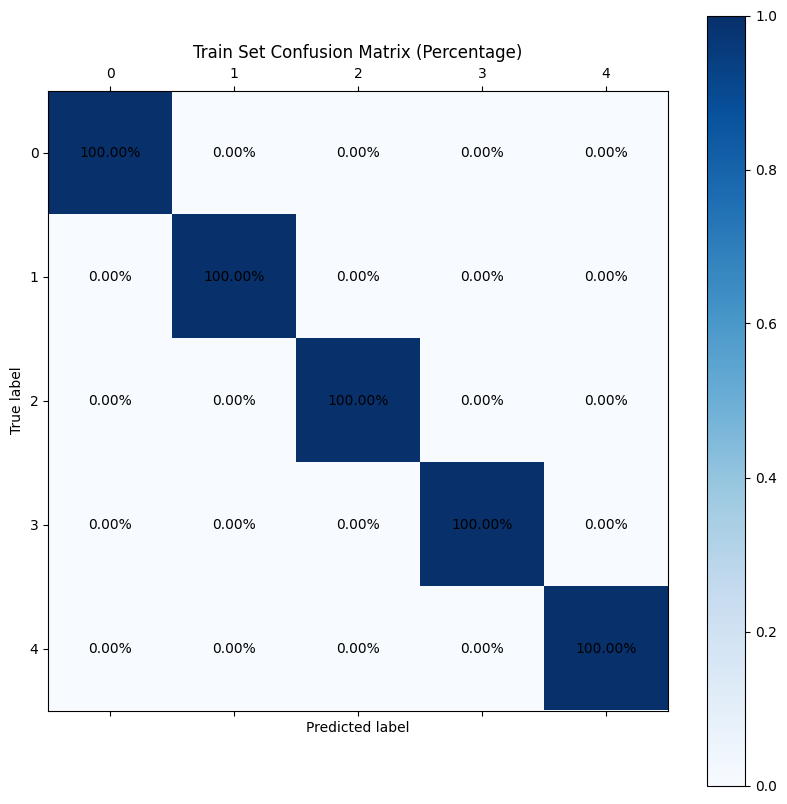

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.50      0.56       152
           1       0.63      0.63      0.63       946
           2       0.75      0.78      0.76      2292
           3       0.68      0.66      0.67      1023
           4       0.52      0.42      0.46       141

    accuracy                           0.70      4554
   macro avg       0.64      0.60      0.62      4554
weighted avg       0.70      0.70      0.70      4554



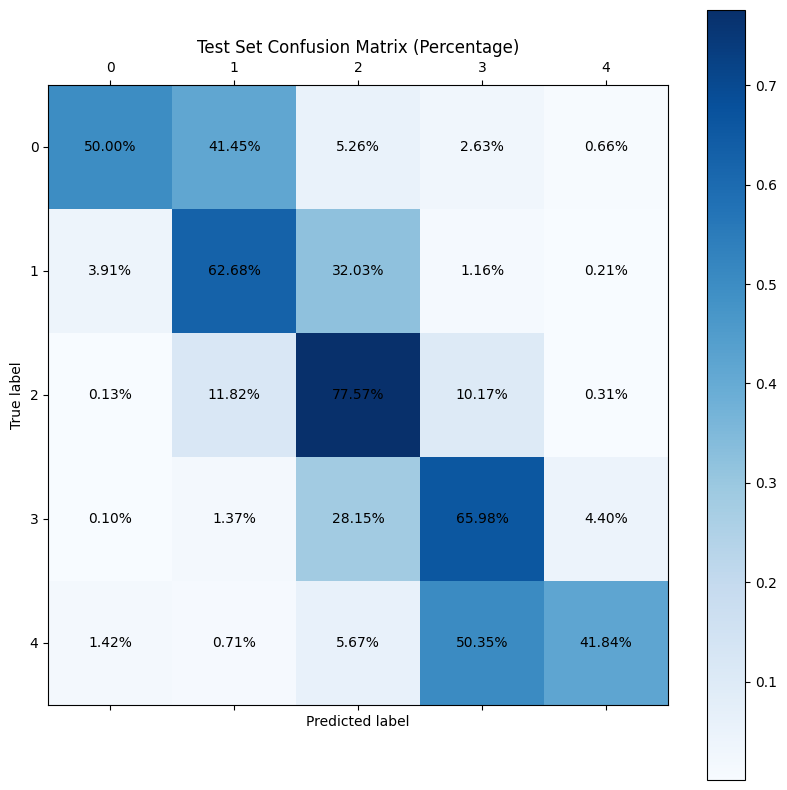

Stacking Model Training Accuracy: 1.0000
Stacking Model Testing Accuracy: 0.6985
Stacking Model Training F1-Score: 1.0000
Stacking Model Testing F1-Score: 0.6966


In [ ]:
# Step 8: Evaluate stacking model and plot confusion matrix (black text)
def plot_confusion_matrix(y_true, y_pred, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(cm_normalized, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    for (i, j), val in np.ndenumerate(cm_normalized):
        ax.text(j, i, f'{val:.2%}', ha='center', va='center', color='black')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1, facecolor='white')
    plt.show()

# Train set evaluation
y_train_pred = meta_model.predict(train_meta_features)
print("Train Set Classification Report:")
print(classification_report(y_train, y_train_pred))
plot_confusion_matrix(y_train, y_train_pred, 'Train Set Confusion Matrix (Percentage)', 'confusion_matrix_train.png')

# Test set evaluation
y_test_pred = meta_model.predict(test_meta_features)
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))
plot_confusion_matrix(y_test, y_test_pred, 'Test Set Confusion Matrix (Percentage)', 'confusion_matrix_test.png')

# Print accuracy and F1-score
stacking_train_f1 = f1_score(y_train, y_train_pred, average='weighted')
stacking_test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Stacking Model Training Accuracy: {stacking_train_accuracy:.4f}")
print(f"Stacking Model Testing Accuracy: {stacking_test_accuracy:.4f}")
print(f"Stacking Model Training F1-Score: {stacking_train_f1:.4f}")
print(f"Stacking Model Testing F1-Score: {stacking_test_f1:.4f}")

# Record F1-scores
with open(f'{directory}/model_parameters.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Stacking Meta-Model F1-Score', stacking_train_f1, stacking_test_f1])


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def preprocess_and_predict(filepath, model, mlp, svc, rnn_wrapper):
    # Read the data
    future_data = pd.read_csv(filepath)

    # Apply the same scaling as training data
    scaler = StandardScaler()
    future_data_scaled = scaler.fit_transform(future_data.iloc[:, 1:].values)
    
    # Calculate 10-day percentage change for 'Close' and discretize it
    future_data_df = pd.DataFrame(future_data_scaled, columns=future_data.columns[1:])
    future_data_df['Close'] = future_data['Close'].values  # retain the original 'Close' values for percentage change calculation
    ten_day_change_future = future_data_df['Close'].pct_change(periods=10) * 100

    fixed_bins = [-float("inf"), -10, -2, 2, 10, float("inf")]
    fixed_labels = [0, 1, 2, 3, 4]

    future_data_df["10_day_change_fixed_discrete"] = pd.cut(
        ten_day_change_future, bins=fixed_bins, labels=fixed_labels
    )

    # Prepare the future data for prediction
    future_data_raw = future_data_df.values
    n_time = len(future_data_raw)
    future_data_list = []

    for index in range(0, n_time - lookback, 10):  # Use the same interval as in training
        future_data_list.append(future_data_raw[index : index + lookback, :-1])  # excluding the discrete change column

    future_data_array = np.array(future_data_list, dtype=np.float32)
    print(f"Future data shape before reshape: {future_data_array.shape}")

    if len(future_data_array.shape) == 3:  # Ensure the data has three dimensions
        future_data_array = future_data_array.reshape(future_data_array.shape[0], -1)
        print(f"Future data shape after reshape: {future_data_array.shape}")
    else:
        print(f"Error: Expected 3 dimensions but got {len(future_data_array.shape)}")
        return pd.Series([])

    # Generate predictions for each base model
    mlp_pred = mlp.predict_proba(future_data_array)
    svc_pred = svc.predict_proba(future_data_array)
    rnn_pred = rnn_wrapper.predict_proba(future_data_array)

    # Concatenate predictions to form new feature set for the meta-model
    meta_features = np.hstack((mlp_pred, svc_pred, rnn_pred))

    # Predict future stock price changes using the meta-model
    future_predictions = model.predict(meta_features)

    # Convert predictions back to DataFrame for easier handling
    future_predictions_df = pd.Series(future_predictions)

    return future_predictions_df

# Create a DataFrame to hold all predictions
all_predictions = []

# Iterate over all CSV files in the directory
directory = "/"
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        print(f"Processing file: {filepath}")

        # Extract the stock code from the filename
        stock_code = os.path.splitext(filename)[0]

        # Perform prediction
        predictions = preprocess_and_predict(filepath, meta_model, mlp, svc, rnn_wrapper)

        # Append predictions to the list
        for prediction in predictions:
            all_predictions.append([stock_code, prediction])

# Convert the list to a DataFrame
predictions_df = pd.DataFrame(all_predictions, columns=["Stock Code", "Prediction"])

# Define the output file path
output_filepath = os.path.join(directory, "all_predictions.csv")

# Check if the file exists
if os.path.exists(output_filepath):
    # If the file exists, load the existing data
    existing_df = pd.read_csv(output_filepath)
    # Append new predictions to the existing data
    updated_df = pd.concat([existing_df, predictions_df], ignore_index=True)
else:
    # If the file does not exist, use the new predictions DataFrame
    updated_df = predictions_df

# Save the DataFrame to a CSV file
updated_df.to_csv(output_filepath, index=False)
print(f"All predictions saved to: {output_filepath}")


Processing file: predict/Finance/0/AGM.csv
Future data shape before reshape: (742, 60, 71)
Future data shape after reshape: (742, 4260)
Processing file: predict/Finance/0/APAM.csv
Future data shape before reshape: (262, 60, 71)
Future data shape after reshape: (262, 4260)
Processing file: predict/Finance/0/BANFP.csv
Future data shape before reshape: (488, 60, 71)
Future data shape after reshape: (488, 4260)
Processing file: predict/Finance/0/BFZ.csv
Future data shape before reshape: (554, 60, 71)
Future data shape after reshape: (554, 4260)
Processing file: predict/Finance/0/BLE.csv
Future data shape before reshape: (529, 60, 71)
Future data shape after reshape: (529, 4260)
Processing file: predict/Finance/0/BTCS.csv
Future data shape before reshape: (320, 60, 71)
Future data shape after reshape: (320, 4260)
Processing file: predict/Finance/0/BX.csv
Future data shape before reshape: (405, 60, 71)
Future data shape after reshape: (405, 4260)
Processing file: predict/Finance/0/BYM.csv
Fu